<a href="https://colab.research.google.com/github/tripathivenkteshwar/digit-recognizer/blob/master/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Digit recognition**


In [1]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.contrib.layers.python.layers.layers import batch_norm
from tensorflow.keras.datasets import mnist
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import math
from tensorflow.python.framework import ops
ops.reset_default_graph()

TensorFlow 1.x selected.


Using TensorFlow backend.


### **Processing data**

**Data split into training/test data*

**image dimension "NHW" (N: sample size; H: height; W: width)*

**Reshape image dimension "NHWC" (N: sample size; H: height; W: width; C: channel)*

**Normalize both tain/test (data/255)*

**one hot encoding of train output/test output*

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255
x_test = x_test/255
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_train=x_train.astype(np.float32)
x_test = x_test.reshape(x_test.shape[0], 28,28,1) 
x_test=x_test.astype(np.float32)
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test)
print("y train", y_train.shape, "y test", y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
y train (60000, 10) y test (10000, 10)


****Weight/bias initialization using xavier***

In [3]:
# Number of class
n_classes=10

weights = {
    # Convolution Layers
    'c1': tf.get_variable('W1', shape=(3,3,1,16), \
            initializer=tf.contrib.layers.xavier_initializer()), 
    'c2': tf.get_variable('W2', shape=(3,3,16,16), \
            initializer=tf.contrib.layers.xavier_initializer()),
    'c3': tf.get_variable('W3', shape=(3,3,16,32), \
            initializer=tf.contrib.layers.xavier_initializer()),
    'c4': tf.get_variable('W4', shape=(3,3,32,32), \
            initializer=tf.contrib.layers.xavier_initializer()),
    
    # Dense Layers
    'd1': tf.get_variable('W5', shape=(7*7*32,128), 
            initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('W6', shape=(128,n_classes), 
            initializer=tf.contrib.layers.xavier_initializer()),
}
biases = {
    # Convolution Layers
    'c1': tf.get_variable('B1', shape=(16), initializer=tf.zeros_initializer()),
    'c2': tf.get_variable('B2', shape=(16), initializer=tf.zeros_initializer()),
    'c3': tf.get_variable('B3', shape=(32), initializer=tf.zeros_initializer()),
    'c4': tf.get_variable('B4', shape=(32), initializer=tf.zeros_initializer()),
    
    # Dense Layers
    'd1': tf.get_variable('B5', shape=(128), initializer=tf.zeros_initializer()),
    'out': tf.get_variable('B6', shape=(n_classes), initializer=tf.zeros_initializer()),
}



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



****Batch Noramlization***


![alt text](https://miro.medium.com/max/506/1*Hiq-rLFGDpESpr8QNsJ1jg.png)


[From the original batch-norm paper](https://arxiv.org/pdf/1502.03167v3.pdf)

In [4]:
def batch_noramlization(x, train_phase, scope_bn):
    if train_phase:
      bn_train = batch_norm(x, decay=0.999, epsilon=1e-3, center=True, scale=True,
              updates_collections=None,
              is_training=True,
              reuse=None, # is this right?
              trainable=True,
              scope=scope_bn)
      return bn_train
    else:
      bn_inference = batch_norm(x, decay=0.999, epsilon=1e-3, center=True, scale=True,
              updates_collections=None,
              is_training=False,
              reuse=True, # is this right?
              trainable=True,
              scope=scope_bn)
      #z = tf.cond(train_phase, lambda: bn_train, lambda: bn_inference)
      return bn_inference


****ConvNet/CNN***

**CNNs in this kernel follow LeNet-5 Architecture with some improvements:*

**Two stacked 3x3 filters replace the single 5x5 filters.*

**Max pooling layers inplaces of Average pooling layers.*

**ReLU activation replaces sigmoid.*

**Batch normalization is added*

**Dropout is added*

In [5]:

def conv2d(x, W, b, strides=1, normalize=False, train_phase=False, scope_bn=None):
    x = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    #if batch_norm:
    #  x=batch_normalization(x)
    if normalize:
      x=batch_noramlization(x, train_phase, scope_bn)
    return tf.nn.relu(x)

def conv_forward_prop(data, weight, biase, training=False):
    # Convolution layers
    conv1 = conv2d(data, weights['c1'], biases['c1'], normalize=True, train_phase=training, scope_bn='bn1') # [28,28,16]
    conv2 = conv2d(conv1, weights['c2'], biases['c2'], normalize=True, train_phase=training, scope_bn='bn2') # [28,28,16]
    pool1 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
    # [14,14,16]

    conv3 = conv2d(pool1, weights['c3'], biases['c3'], normalize=True, train_phase=training, scope_bn='bn3') # [14,14,32]
    conv4 = conv2d(conv3, weights['c4'], biases['c4'], normalize=True, train_phase=training, scope_bn='bn4') # [14,14,32]
    pool2 = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
    # [7,7,32]

    # Flatten
    flat = tf.reshape(pool2, [-1, weights['d1'].get_shape().as_list()[0]]) 
    # [7*7*32] = [1568]

    # Fully connected layer
    fc1 = tf.add(tf.matmul(flat, weights['d1']), biases['d1']) # [128]
    fc1 = tf.nn.relu(fc1) # [128]

    # Dropout
    if training:
        fc1 = tf.nn.dropout(fc1, rate=0.2)

    # Output
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out']) # [10]
    return out

****Cost function***

In [6]:
def compute_cost(Z3, Y):
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3, labels=Y))
  return cost

****Placeholder for input(X)/output(Y)***

In [7]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])

    return X, Y

****Mini batch of shuffled data***

In [8]:

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

****Final model:***

**Create placeholder for data feeding/output*

**Foraward pass*

**Cost calculation*

**Adam Optimizer on cost*

In [9]:
def model(X_train, Y_train, X_test, Y_test, 
          learning_rate = 0.009,
          num_epochs = 50, minibatch_size = 64,
          print_cost = True, training=False):

    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]

    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
  
    Z3 = conv_forward_prop(X, weights, biases, training=training)
    #with tf.GradientTape() as tape:
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3, labels=Y))

    #cost = compute_cost(Z3, Y)
	  
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    costs=[]
    with tf.Session() as sess:
      #writer=tf.summary.FileWriter("./log", sess.graph)
      sess.run(tf.global_variables_initializer())
      sess.run(tf.local_variables_initializer())
      
      for epoch in range(num_epochs):
              
              minibatch_cost = 0.
              
              num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
              
              minibatches = random_mini_batches(X_train, Y_train, mini_batch_size=minibatch_size)

              for minibatch in minibatches:
                
                (minibatch_X, minibatch_Y) = minibatch

                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                

                minibatch_cost += temp_cost / num_minibatches

              # Print the cost every epoch
              if print_cost == True and epoch % 5 == 0:
                  print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
              if print_cost == True and epoch % 1 == 0:
                  costs.append(minibatch_cost)
      #writer.close()

      plt.plot(np.squeeze(costs))
      plt.ylabel('cost')
      plt.xlabel('iterations (per tens)')
      plt.title("Learning rate =" + str(learning_rate))
      plt.show()
      predict_op = tf.argmax(Z3, 1)
      correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

      accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
      print("accuracy", accuracy)
      train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
      test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
      print("Train Accuracy:", train_accuracy)
      print("Test Accuracy:", test_accuracy)
      
      predictions = sess.run(tf.argmax(conv_forward_prop(X_test[:25,:,:,:], weights, biases), axis=1))
      f, axarr = plt.subplots(2, 5, figsize=(15,5))
      for idx in range(10):
          axarr[int(idx/5), idx%5].imshow(np.squeeze(X_test[idx]), cmap='gray')
          axarr[int(idx/5), idx%5].set_title(str(predictions[idx]),fontsize=20)
      if training:
          saver = tf.train.Saver() 
          saver.save(sess, 'my_test_model.ckpt')

Cost after epoch 0: 0.602881
Cost after epoch 5: 0.072185
Cost after epoch 10: 0.041337
Cost after epoch 15: 0.032591
Cost after epoch 20: 0.028220
Cost after epoch 25: 0.024652
Cost after epoch 30: 0.026933
Cost after epoch 35: 0.022816
Cost after epoch 40: 0.020905
Cost after epoch 45: 0.024450


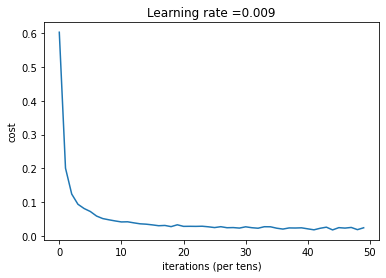

accuracy Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.99525
Test Accuracy: 0.9894


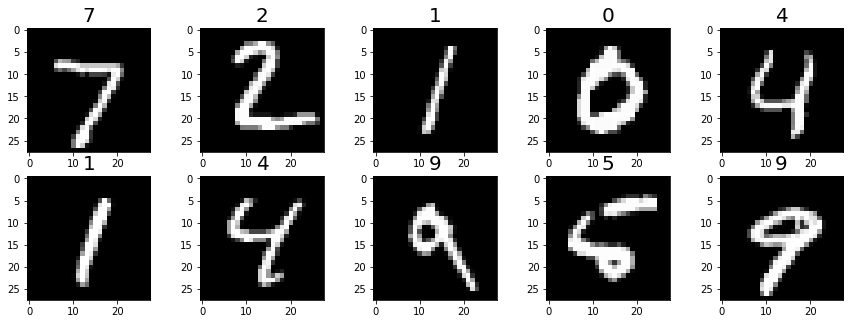

In [10]:
model(x_train[:,:,:,:], y_train[:,:], x_test[:,:,:,:], y_test[:,:], training=True)

INFO:tensorflow:Restoring parameters from ./my_test_model.ckpt


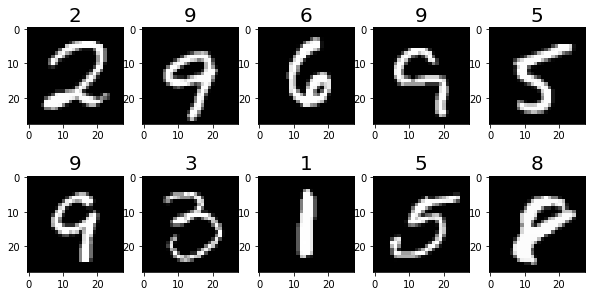

In [11]:
#testing
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('./'))

predictions = sess.run(tf.argmax(conv_forward_prop(x_test[:,:,:,:], weights, biases), axis=1))
#predictions = np.argmax(np.squeeze(onehot_predictions), axis=1)
idx = 35
f, axarr = plt.subplots(2, 5, figsize=(10,5))
for i in range(2):
    for j in range(5):
        axarr[i,j].imshow(np.squeeze(x_test[idx]), cmap='gray')
        axarr[i,j].set_title(str(predictions[idx]),fontsize=20)
        idx += 23